# Claira Project: Mortgage Contracts

## Import Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import string
import numpy as np
import gzip
import seaborn as sns
np.random.seed(99)
RANDOM_STATE = 99
import datetime
pd.set_option('display.max_rows', 151)
pd.set_option('display.max_columns', 30)


# Import vectorizing and modeling tools in preparation for modeling steps
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.feature_extraction import text, stop_words
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import time

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

import spacy
import en_core_web_lg
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
nlp = spacy.load('en_core_web_sm', disable = ['ner', 'parser'])

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_curve, auc

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


## Define sub-functions

In [2]:
# printing functions
def explore_data_cleaning(raw_df):
    trigger_order = raw_df['Trigger'].value_counts().sort_values(ascending = False).index

    fig = plt.gcf()
    fig.set_size_inches(8, 8)
    ax = sns.countplot(y=raw_df['Trigger'], data=raw_df, orient = 'h', order = trigger_order)
    ax.set_title('Number of Trigger Types');

    for p in ax.patches:
        ax.annotate(int(p.get_width()),((p.get_x() + p.get_width()), p.get_y()), xytext=(17, -15),fontsize=9,textcoords='offset points', horizontalalignment='right')

    #https://stackoverflow.com/questions/50190409/how-to-annotate-horizontal-seaborn-countplots
    return

In [3]:
# function to get data 
def get_data():
    # Import the CSV file
    raw_df = pd.read_csv('../data/sasb_cash_trap_triggers_06_09_20.csv')
    return raw_df

# function to clean data
def clean_data(raw_df, print_fns=False):
    # project out extra columns
    raw_df = raw_df[['Document', 'Sentence', 'Trigger', 'Multiclass']]
    
    # Convert each category to Title format (to remove discrepancies based on capitalization)
    raw_df['Trigger'] = raw_df['Trigger'].str.title()

    # Some data fixes
    raw_df['Trigger'] = raw_df['Trigger'].str.replace('Falll', 'Fall')
    raw_df.loc[raw_df['Trigger'] == 'Aggregate Debt Yield', 'Trigger'] = 'Aggregate Debt Yield Fall'

    # Some dollar sign symbols are causing problems - will remove them here
    raw_df['Sentence'] = raw_df['Sentence'].replace({'\$':''}, regex = True)

    # Drop Multiclass column since it isn't needed
    raw_df = raw_df.drop('Multiclass', axis = 1)
    
    # Count the number of distinct documents
    num_docs = raw_df['Document'].nunique()
    print(f'{num_docs} unique documents have been included in the data set')
    
    # Summarize the trigger counts for the existing Document set
    max_triggers = raw_df['Document'].value_counts().max()
    min_triggers = raw_df['Document'].value_counts().min()
    print(f'The {num_docs} Documents have tag counts that range from {min_triggers} to {max_triggers}.')

    # run the extra code that analyzes the data
    if print_fns:
        explore_data_cleaning(raw_df)
        
    return raw_df


In [4]:
# function to reshape the dataframe such that the triggers are 0/1 columns. Remove duplicates
def reshape_trigger_representation(dataframe):
    # select trigger types
    trigger_types = list(dataframe['Trigger'].unique())
    trigger_types = [x for x in trigger_types if str(x) != 'nan']

    # create new dataframe with unique document-sentence pairs (no duplicates)
    reshaped = dataframe.drop('Trigger', axis = 1).drop_duplicates().reset_index().drop('index', axis = 1)

    # select rows by trigger, reassign as 1 or 0 (for True or False)
    for tt in trigger_types:
        # select part that is trigger_type
        temp = dataframe.loc[dataframe['Trigger'] == tt].copy()

        # create a new column of true with trigger name
        temp[tt.lower().replace(' ', '_')] = np.int64(1)
        temp.drop('Trigger', axis=1, inplace=True)
        temp[tt.lower().replace(' ', '_')] = temp[tt.lower().replace(' ', '_')].astype('Int64')

        # left join this adjusted column to the unique data
        reshaped = reshaped.merge(temp, how='left', left_on=['Document', 'Sentence'], right_on=['Document', 'Sentence'])

    # replace nulls with False
    reshaped = reshaped.fillna(0)  
    
    return reshaped

In [5]:
# Shall we create doc view and remove the extraneous document without tags?

In [6]:
def tokenize(text):
    doc = nlp(text)
    tokens = [token.text for token in doc]
    return ' '.join(tokens)

In [7]:
def lemmatize(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]
    return ' '.join(lemmas)

In [8]:
# NLP processing the sentence columns to prep for models
def tokenize_sentences(dataframe):
    print('Tokenizing the input sentences...')
    dataframe['SentenceTokens'] = dataframe['Sentence'].apply(tokenize)
    dataframe['SentenceLemmas'] = dataframe['Sentence'].apply(lemmatize)
    print(f"{len(dataframe['Sentence'])} sentences have been tokenized and lemmatized.")
    print("\n")
    return dataframe

In [9]:
# Incorporate Stopwords
def get_stopwords():
    # might need space
    short_stopwords = ['the', 'to', 'of', 'be', 'and', 'in', 'a']
    short_stopwords2 = ['the', 'and', 'a', 'to', 'it', 'be', 'for', 'with', 'that']
    stopwords = list(STOP_WORDS)

    return short_stopwords, short_stopwords2, stopwords

In [10]:
# function to split data for each target column (trigger type)
def get_split_data(df, target_info):
    # extract target name
    target = target_info['target']
    model_input  = target_info['model_input']
    


    # create X, Y
    X = df[model_input]
    y = df[target]
    indices = df.index

    print(f"Number of labeled instances within the full sentence data set: {y.value_counts()[1]}")   
    
    y = y.astype('int')

    # run test, train split
    X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, test_size = 0.3, stratify = y, random_state = RANDOM_STATE)

    # print information


#    print(indices_train.shape, indices_test.shape)
    
    # create output dictionary
    split_data = {}
    split_data['X_train'] = X_train
    split_data['X_test'] = X_test
    split_data['y_train'] = y_train
    split_data['y_test'] = y_test
    split_data['indices_train'] = indices_train
    split_data['indices_test'] = indices_test
    
    return split_data

In [11]:
# run the model with the chosen model and metric
def run_model(split_data, target_info):

    # get stopwords
    short_stopwords, short_stopwords2, stopwords = get_stopwords()
    
    # set pipeline according to the selected model:
    if target_info['model'] == 'lr':
        # Define CVEC + Logistic Regression Pipeline
        pipe = Pipeline([('cvec', CountVectorizer()), ('lr', LogisticRegression(solver = 'liblinear', random_state = RANDOM_STATE))])
        params = {
            'cvec__ngram_range': [(1,2), (1,3), (1,4), (1,5), (1,6), (1,7)],
            'cvec__stop_words': [None, short_stopwords, short_stopwords2, stopwords],  
            'cvec__max_features': [100, 200, 400, 600, 1000],
            'cvec__min_df': [2],
            'cvec__max_df': [.99],
            }

    elif target_info['model'] == 'rf':
        # Define CVEC + Logistic Regression Pipeline
        pipe = Pipeline([('cvec', CountVectorizer()), ('rf', RandomForestClassifier(random_state = RANDOM_STATE, n_jobs = 2))])
        params = {
            'cvec__ngram_range': [(1,2), (1,3), (1,4), (1,5)],
            'cvec__stop_words': [None, short_stopwords, short_stopwords2],  
            'cvec__max_features': [100, 200, 400, 800],
            'cvec__min_df': [2],
            'cvec__max_df': [.99],
            'rf__max_depth': [4,5, 6],
            'rf__min_samples_split': [2,3],
            'rf__min_samples_leaf': [10, 12]
            }

    
    else:
        print('did not specify model throw error')

    # define pipeline
    gs_model = GridSearchCV(pipe, param_grid = params, cv = 3, scoring = target_info['metric'])

    # Start the timer.
    t0 = time.time()

    # extract x/y_train
    X_train = split_data['X_train']
    y_train = split_data['y_train']
    
    # run pipeline
    model_result = gs_model.fit(X_train, y_train)

    print(f"Seconds elapsed for fitting: {(time.time() - t0):.3f}") # How many seconds elapsed.   
    return model_result


## Main Control Function - runs the full model for all target types

In [12]:
# Control of the main project

# define dictionary of targets contains: tag, model, metric, input, order
target_dict = {}
target_dict['nontrigger'] = {'target': 'nontrigger', 'model': 'lr', 'metric': 'f1', 'model_input': 'Sentence'}
target_dict['loan_default'] = {'target': 'loan_default', 'model': 'lr', 'metric':'accuracy', 'model_input':'Sentence'}
target_dict['unspecified'] = {'target': 'unspecified', 'model': 'lr', 'metric':'accuracy', 'model_input':'Sentence'}
target_dict['debt_yield_fall'] = {'target': 'debt_yield_fall', 'model': 'lr', 'metric': 'f1', 'model_input': 'Sentence'}
target_dict['mezzanine_default'] = {'target': 'mezzanine_default', 'model': 'lr', 'metric': 'f1', 'model_input': 'Sentence'}
target_dict['tenant_failure'] = {'target': 'tenant_failure', 'model': 'lr', 'metric': 'f1', 'model_input': 'Sentence'}
target_dict['bankruptcy'] = {'target': 'bankruptcy', 'model': 'lr', 'metric': 'accuracy', 'model_input': 'Sentence'}
target_dict['aggregate_debt_yield_fall'] = {'target': 'aggregate_debt_yield_fall', 'model': 'lr', 'metric': 'f1', 'model_input': 'Sentence'}
target_dict['dscr_fall'] = {'target': 'dscr_fall', 'model': 'lr', 'metric': 'f1', 'model_input': 'Sentence'}
target_dict['renovations'] = {'target': 'renovations', 'model': 'lr', 'metric': 'f1', 'model_input': 'Sentence'}
target_dict['operator_termination'] = {'target': 'operator_termination', 'model': 'lr', 'metric': 'f1', 'model_input': 'Sentence'}
target_dict['sponsor_termination'] = {'target': 'sponsor_termination', 'model': 'lr', 'metric': 'f1', 'model_input': 'Sentence'}
target_dict['mezzanine_outstanding'] = {'target': 'mezzanine_outstanding', 'model': 'lr', 'metric': 'f1', 'model_input': 'Sentence'}
target_dict['aggregate_dscr_fall'] = {'target': 'aggregate_dscr_fall', 'model': 'lr', 'metric': 'f1', 'model_input': 'Sentence'}
target_dict['sff'] = {'target': 'sff', 'model': 'lr', 'metric': 'f1', 'model_input': 'Sentence'}

# set output_dict - will contain target + output of calculations
output_dict = {}

# get data
raw_df = get_data()
raw_df = clean_data(raw_df)

# Reshape our original dataframe and tokenize to prepare sentences for models
df = reshape_trigger_representation(raw_df)
df = tokenize_sentences(df)

# run for each model definition
for k,v in target_dict.items():
    
    print(f"{target_dict[k]['target'].replace('_', ' ').title()}: creating Train-Test split")
    # get split data
    split_data = get_split_data(df, v)
    
    print(f"Model fit in progress: {target_dict[k]}")
    # run model
    model_result = run_model(split_data, v)
    
    # make the output dictionary
    output_dict[k] = v
    output_dict[k]['split_data'] = split_data
    output_dict[k]['model_result'] = model_result

    
    print(f"Best fit parameters: {model_result.best_params_}")
    print(f"Best fit 3-fold cross validation score: {model_result.best_score_:.3f}")
    print(f"{target_dict[k]['target'].replace('_', ' ').title()} {target_dict[k]['metric']} Train score: {model_result.score(split_data['X_train'], split_data['y_train']):.3f}")
    print(f"{target_dict[k]['target'].replace('_', ' ').title()} {target_dict[k]['metric']} Test score: {model_result.score(split_data['X_test'], split_data['y_test']):.3f}")
    print("\n")
    
    output_dict[k]['best_params'] = model_result.best_params_
    output_dict[k]['count'] = df[target_dict[k]['target']].value_counts()[1]
    output_dict[k]['best_crossval_score'] = model_result.best_score_
    output_dict[k]['train_score'] = model_result.score(split_data['X_train'], split_data['y_train'])
    output_dict[k]['test_score'] = model_result.score(split_data['X_test'], split_data['y_test'])                                                  
    

full_output_dict = [output_dict[key] for key in output_dict.keys()]
results_df = pd.DataFrame.from_dict(full_output_dict)
    
print("Modeling complete!")





27 unique documents have been included in the data set
The 27 Documents have tag counts that range from 25 to 176.
Tokenizing the input sentences...
2041 sentences have been tokenized and lemmatized.


Nontrigger: creating Train-Test split
Number of labeled instances within the full sentence data set: 1056
Model fit in progress: {'target': 'nontrigger', 'model': 'lr', 'metric': 'f1', 'model_input': 'Sentence'}
Seconds elapsed for fitting: 175.184
Best fit parameters: {'cvec__max_df': 0.99, 'cvec__max_features': 600, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 4), 'cvec__stop_words': ['bottom', 'for', 'whereby', 'further', 'of', 'somehow', 'whereupon', 'whoever', 'thereupon', 'say', 'himself', 'my', 'amongst', 'formerly', 'indeed', 'meanwhile', 'why', 'per', 'third', 'which', 'else', 'it', 'fifty', 'down', 'around', 'hers', 'are', 'twenty', 'unless', 'anything', 'did', 'after', 'some', 'behind', 'this', 'using', 'when', 'whereafter', 'due', 'hence', 'his', 'latter', 'really', 'last', 't

Bankruptcy f1 Test score: 0.905


Aggregate Debt Yield Fall: creating Train-Test split
Number of labeled instances within the full sentence data set: 18
Model fit in progress: {'target': 'aggregate_debt_yield_fall', 'model': 'lr', 'metric': 'f1', 'model_input': 'Sentence'}
Seconds elapsed for fitting: 285.553
Best fit parameters: {'cvec__max_df': 0.99, 'cvec__max_features': 200, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': ['bottom', 'for', 'whereby', 'further', 'of', 'somehow', 'whereupon', 'whoever', 'thereupon', 'say', 'himself', 'my', 'amongst', 'formerly', 'indeed', 'meanwhile', 'why', 'per', 'third', 'which', 'else', 'it', 'fifty', 'down', 'around', 'hers', 'are', 'twenty', 'unless', 'anything', 'did', 'after', 'some', 'behind', 'this', 'using', 'when', 'whereafter', 'due', 'hence', 'his', 'latter', 'really', 'last', 'two', 'used', 'via', 'whither', 'our', 'between', 'may', 'much', 'that', 'then', 'full', 'does', 'various', 'first', 'perhaps', 'however', 'n

Renovations f1 Test score: 0.800


Operator Termination: creating Train-Test split
Number of labeled instances within the full sentence data set: 19
Model fit in progress: {'target': 'operator_termination', 'model': 'lr', 'metric': 'f1', 'model_input': 'Sentence'}
Seconds elapsed for fitting: 279.920
Best fit parameters: {'cvec__max_df': 0.99, 'cvec__max_features': 400, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': ['bottom', 'for', 'whereby', 'further', 'of', 'somehow', 'whereupon', 'whoever', 'thereupon', 'say', 'himself', 'my', 'amongst', 'formerly', 'indeed', 'meanwhile', 'why', 'per', 'third', 'which', 'else', 'it', 'fifty', 'down', 'around', 'hers', 'are', 'twenty', 'unless', 'anything', 'did', 'after', 'some', 'behind', 'this', 'using', 'when', 'whereafter', 'due', 'hence', 'his', 'latter', 'really', 'last', 'two', 'used', 'via', 'whither', 'our', 'between', 'may', 'much', 'that', 'then', 'full', 'does', 'various', 'first', 'perhaps', 'however', 'neverthele

Sff f1 Test score: 0.000


Modeling complete!


In [13]:
# Print a summary table with all fitting results
results_df

,target,model,metric,model_input,split_data,model_result,best_params,count,best_crossval_score,train_score,test_score
0,nontrigger,lr,f1,Sentence,{'X_train': ['“True Up Payment” means a paymen...,"GridSearchCV(cv=3, error_score=nan,\n ...","{'cvec__max_df': 0.99, 'cvec__max_features': 6...",1056,0.975479,0.991837,0.976526
1,loan_default,lr,accuracy,Sentence,{'X_train': ['Because some funds may be receiv...,"GridSearchCV(cv=3, error_score=nan,\n ...","{'cvec__max_df': 0.99, 'cvec__max_features': 2...",459,0.980392,0.993697,0.977162
2,unspecified,lr,accuracy,Sentence,"{'X_train': ['However, the inability of the Bo...","GridSearchCV(cv=3, error_score=nan,\n ...","{'cvec__max_df': 0.99, 'cvec__max_features': 6...",356,0.959384,0.997899,0.959217
3,debt_yield_fall,lr,f1,Sentence,{'X_train': ['All interest in the Required Ren...,"GridSearchCV(cv=3, error_score=nan,\n ...","{'cvec__max_df': 0.99, 'cvec__max_features': 1...",204,0.956984,1.000000,0.966667
4,mezzanine_default,lr,f1,Sentence,{'X_train': ['Amounts deposited in the Replace...,"GridSearchCV(cv=3, error_score=nan,\n ...","{'cvec__max_df': 0.99, 'cvec__max_features': 4...",105,0.951797,1.000000,0.918033
5,tenant_failure,lr,f1,Sentence,{'X_train': ['There is a risk that the Borrowe...,"GridSearchCV(cv=3, error_score=nan,\n ...","{'cvec__max_df': 0.99, 'cvec__max_features': 4...",37,0.885714,1.000000,0.857143
6,bankruptcy,lr,f1,Sentence,{'X_train': ['During the continuance of a Mort...,"GridSearchCV(cv=3, error_score=nan,\n ...","{'cvec__max_df': 0.99, 'cvec__max_features': 6...",77,0.900348,0.990826,0.904762
7,aggregate_debt_yield_fall,lr,f1,Sentence,{'X_train': ['If the amount of the Condo Asses...,"GridSearchCV(cv=3, error_score=nan,\n ...","{'cvec__max_df': 0.99, 'cvec__max_features': 2...",18,0.555556,1.000000,0.888889
8,dscr_fall,lr,f1,Sentence,{'X_train': ['Pursuant to the Cash Management ...,"GridSearchCV(cv=3, error_score=nan,\n ...","{'cvec__max_df': 0.99, 'cvec__max_features': 4...",25,0.902357,1.000000,0.857143
9,renovations,lr,f1,Sentence,{'X_train': ['Pursuant to the Cash Management ...,"GridSearchCV(cv=3, error_score=nan,\n ...","{'cvec__max_df': 0.99, 'cvec__max_features': 2...",24,0.878788,0.969697,0.800000


## Plotting functions: features and confusion matrices

In [14]:
def coefficient_plots(results_df):
    '''
    Plots the top 10 and bottom 10 coefficients for each category
    '''
    for row in results_df.itertuples(index = True, name = 'Pandas'):
        names = getattr(row, "model_result").best_estimator_.steps[0][1].get_feature_names()
        betas = getattr(row, "model_result").best_estimator_.named_steps['lr']
        coef = np.array(betas.coef_).tolist()[0]
        top_words = list(zip(names, coef))
        df_coefs = pd.DataFrame(top_words).rename(columns = {0: 'word', 1: 'coef'}).sort_values(by = 'coef', ascending = True)
        

        coefs_1 = df_coefs.sort_values(by = 'coef', ascending=False).tail(10) # getting the top 10 coefficients
        coefs_2 = df_coefs.sort_values(by = 'coef', ascending=False).head(10) # getting the bottom 10 coefficients
        coefs = pd.concat([coefs_2, coefs_1], axis = 0) # merging the two into one
        # plotting importance
        plt.figure(figsize=(10, 8)) # plotting the coefficients
        plt.title(f'Feature Coefficients for {getattr(row,"target").replace("_", " ").title()}', fontsize=25)
        sns.set_style("darkgrid")
        sns.barplot(data=coefs,
                    x= 'coef',
                    y='word',
                    orient='h',
                    palette = 'PuBuGn_d')
        plt.xlabel('coefficient', fontsize=15)
        plt.ylabel('feature', fontsize=15)
        plt.tick_params(labelsize=15)


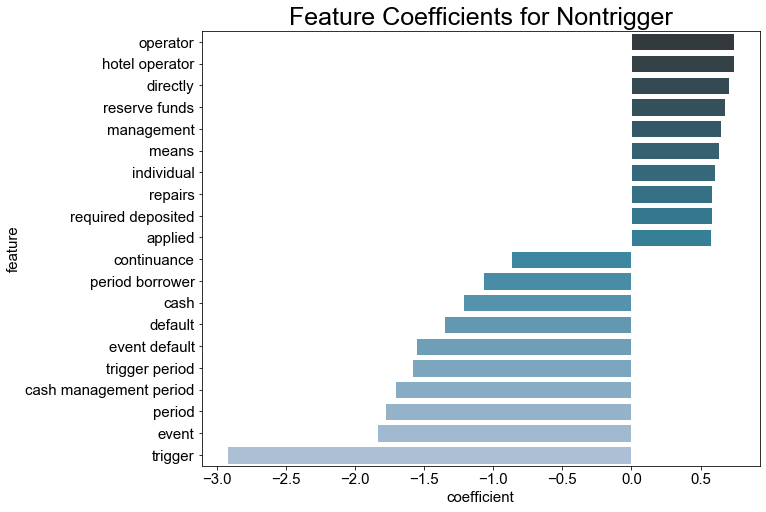

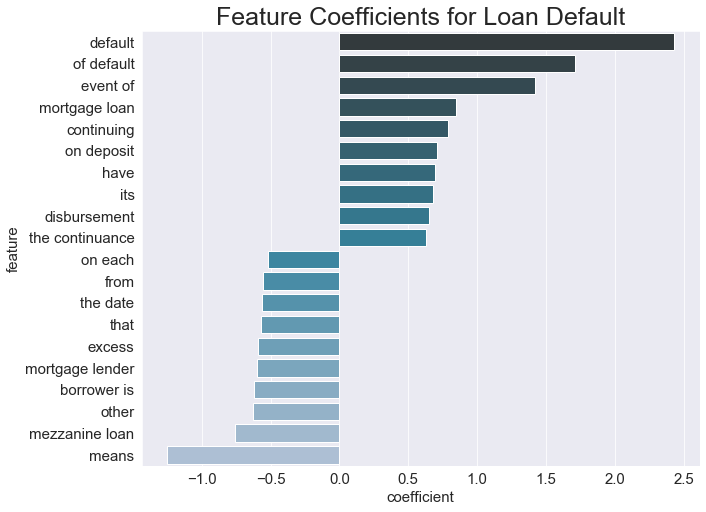

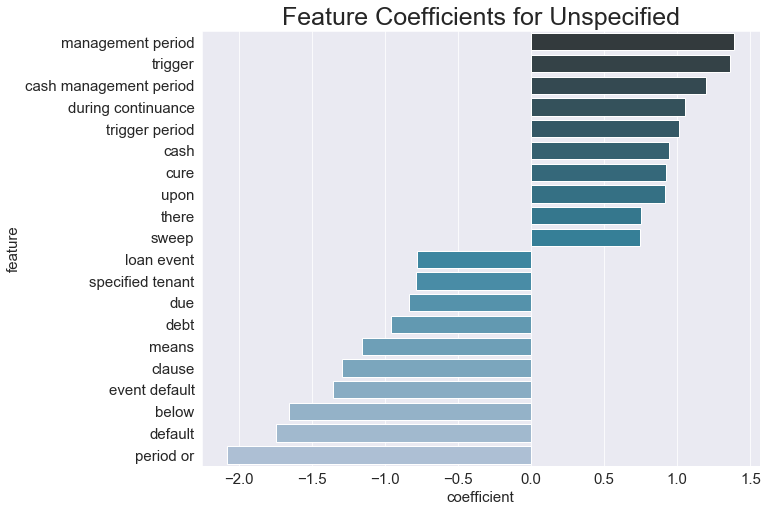

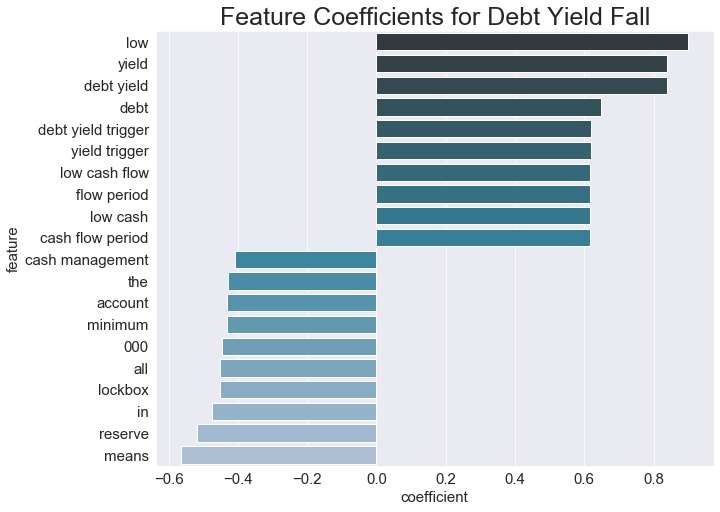

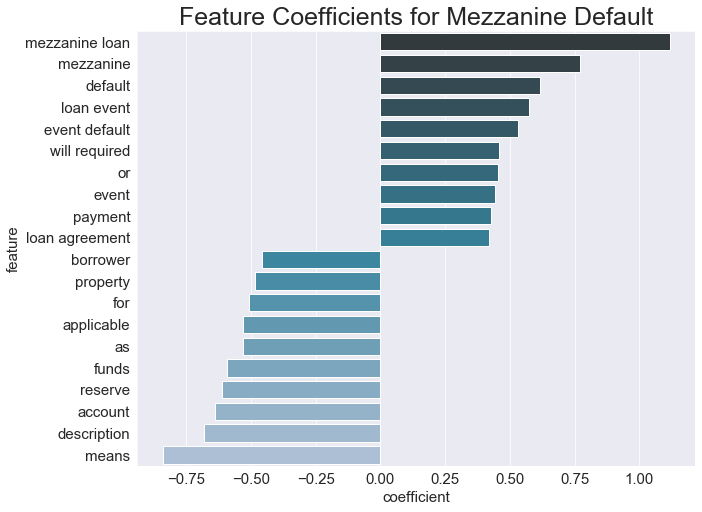

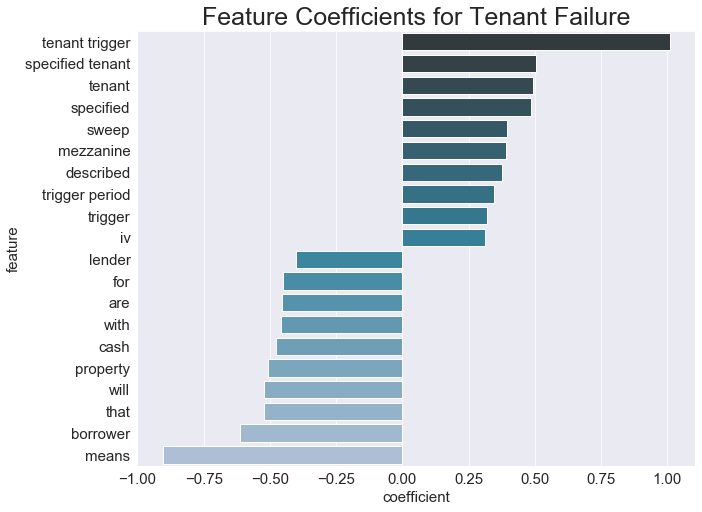

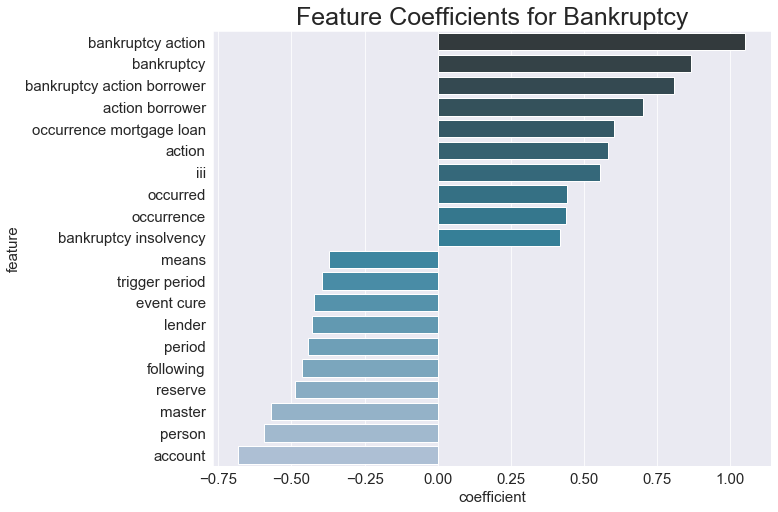

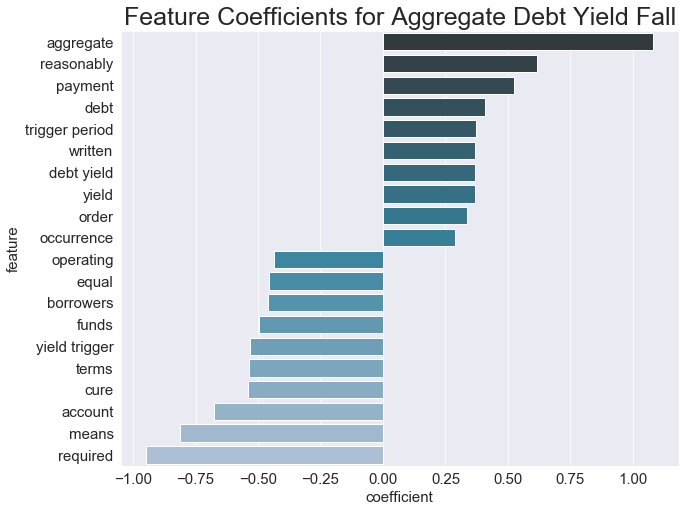

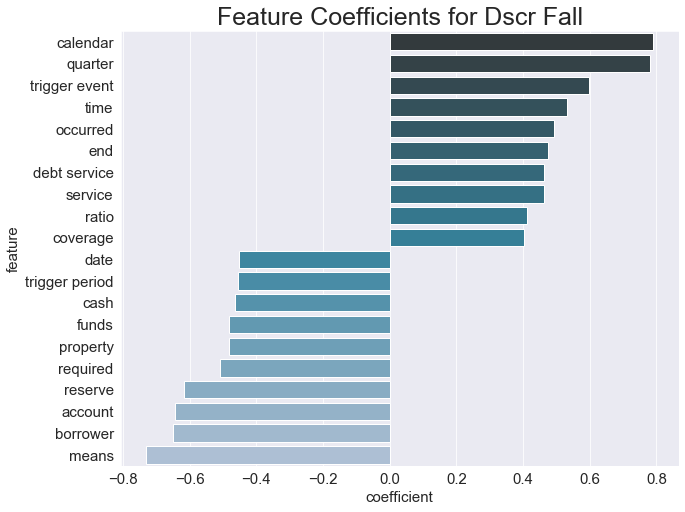

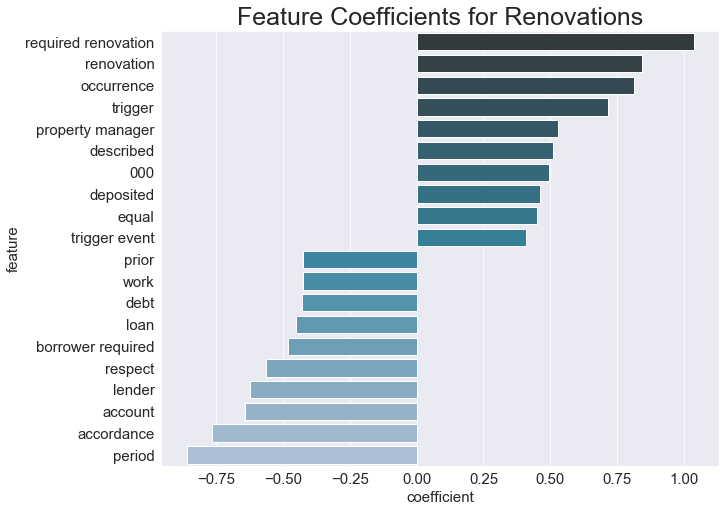

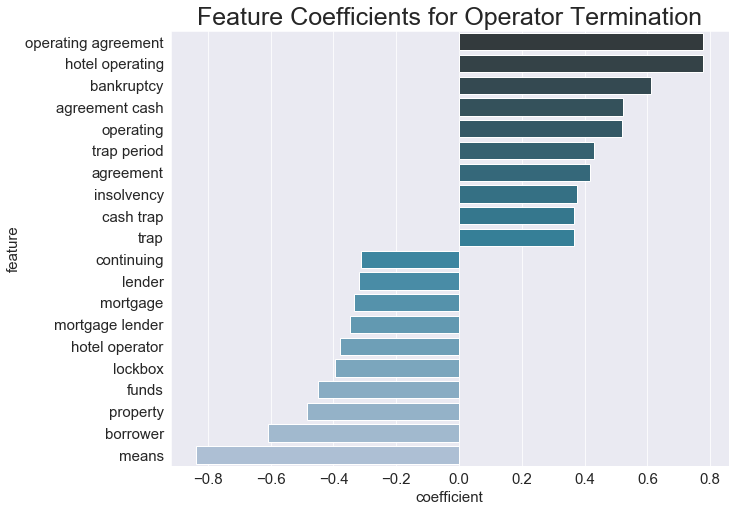

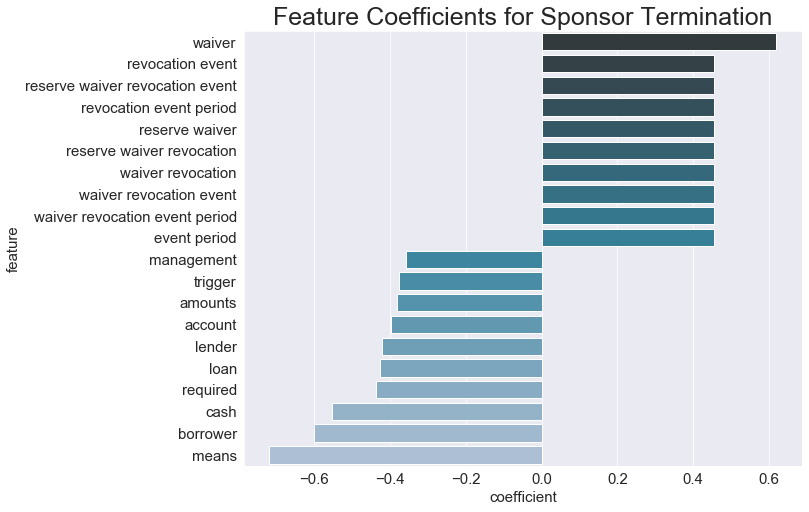

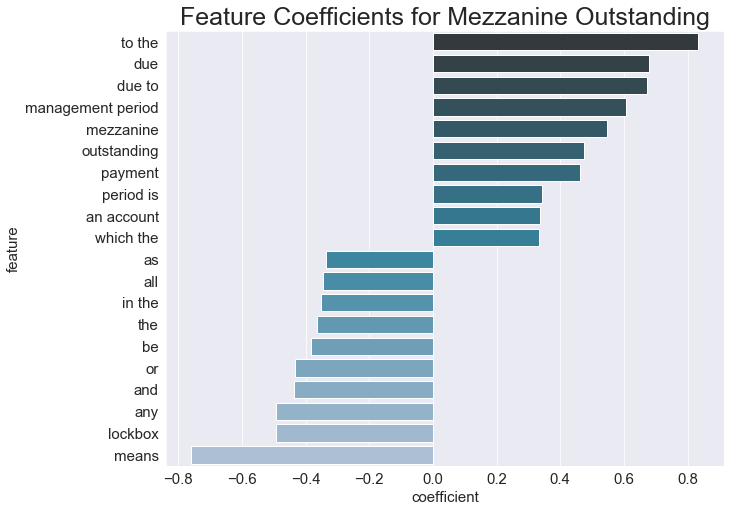

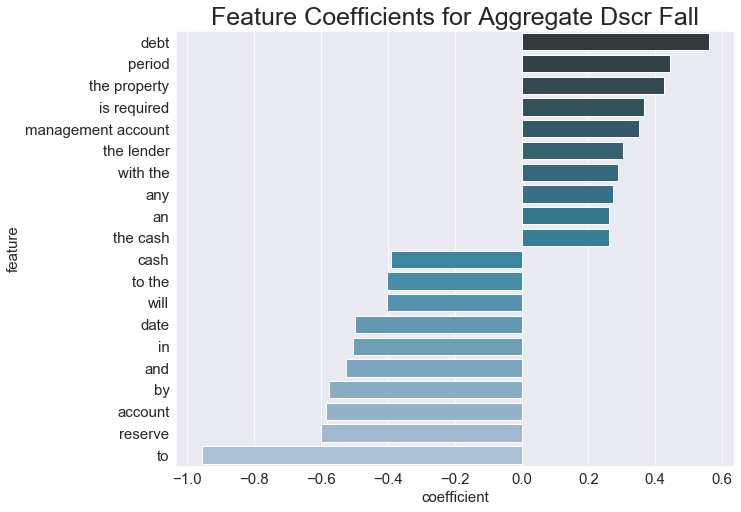

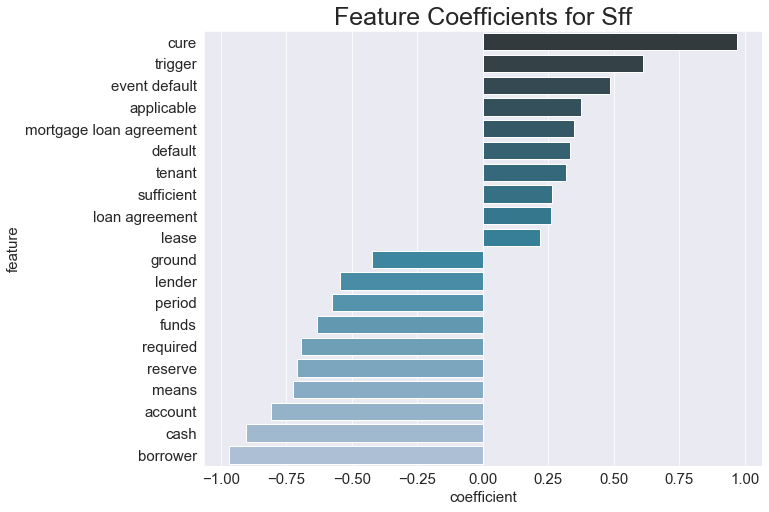

In [15]:
# Call the coefficient plot function
coefficient_plots(results_df)

In [16]:
def create_confusion_matrix(results_df):
    '''
    Plots the top 10 and bottom 10 coefficients for each category
    '''
    for row in results_df.itertuples(index = True, name = 'Pandas'):
        best_model = getattr(row, "model_result").best_estimator_
        preds = best_model.predict(getattr(row, "split_data")['X_test'])
        
        cm_test = confusion_matrix(getattr(row, "split_data")['y_test'], preds)
        cm_test = pd.DataFrame(cm_test, columns=['Predicted Negative','Predicted Positive'], 
                       index=['Actual Negative','Actual Positive'])
        plt.figure(figsize = (6,6))
        ax = plt.subplot()
        sns.heatmap(cm_test, 
            annot=True, 
            ax = ax, 
            fmt='g', 
            cbar=False,
            cmap="Blues"); #annot=True to annotate cells

        # labels, title and ticks
        ax.set_title(f'Confusion Matrix - {getattr(row,"target").replace("_", " ").title()}', size=16)
        ax.set_xlabel('Predicted', size=14)
        ax.set_ylabel('Actual', size=14)
        ax.xaxis.set_ticklabels(['Negative', 'Positive'])
        ax.yaxis.set_ticklabels(['Negative', 'Positive']);

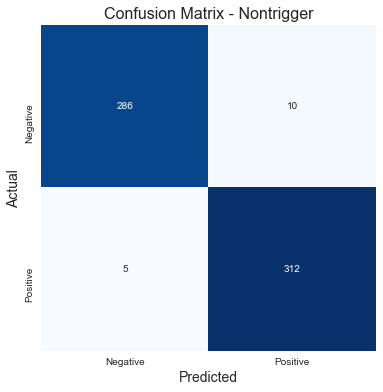

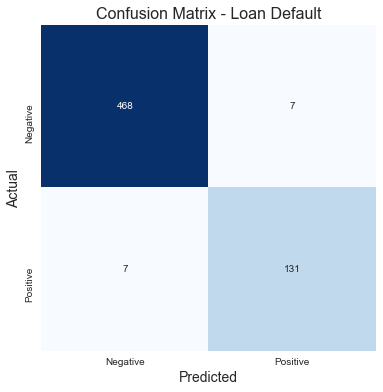

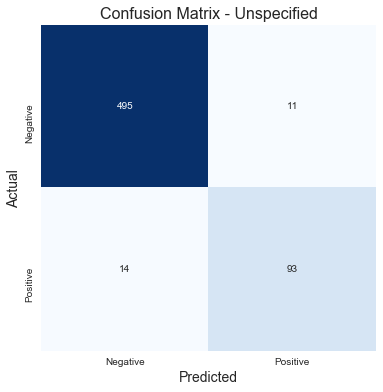

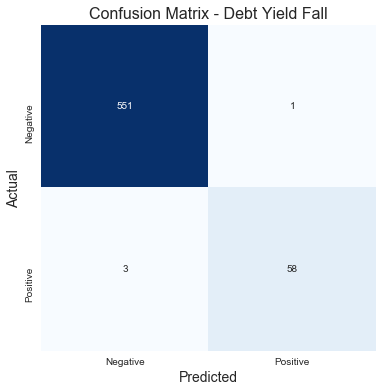

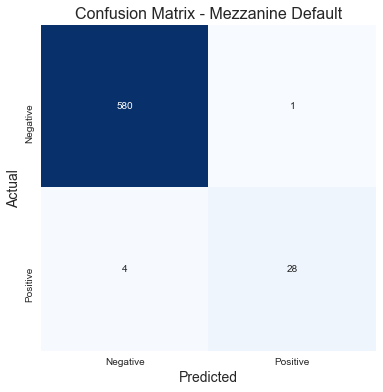

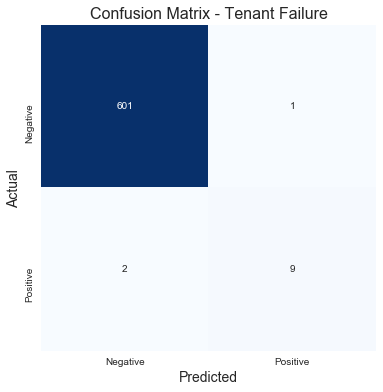

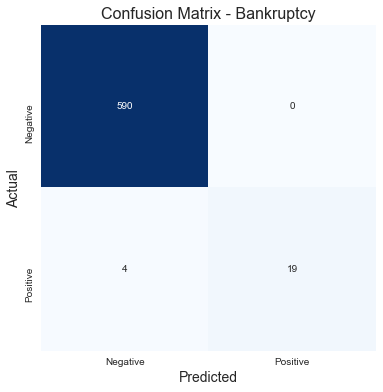

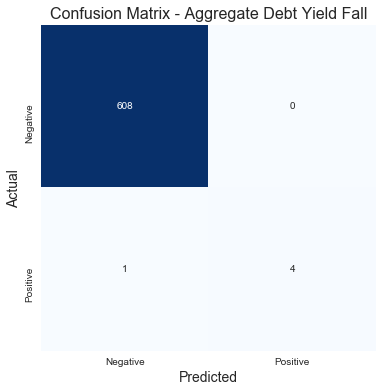

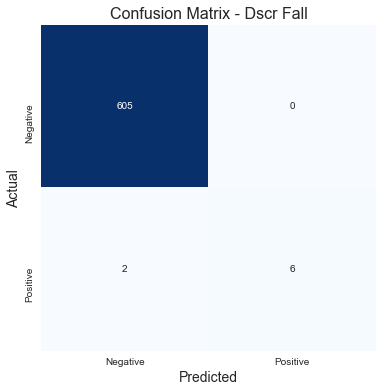

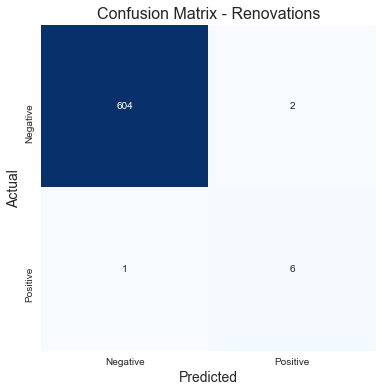

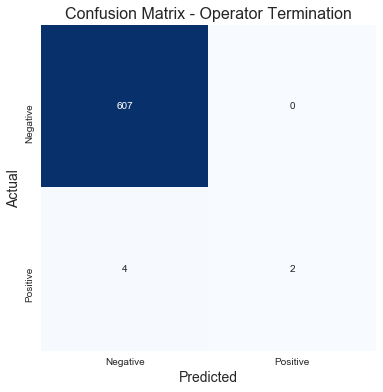

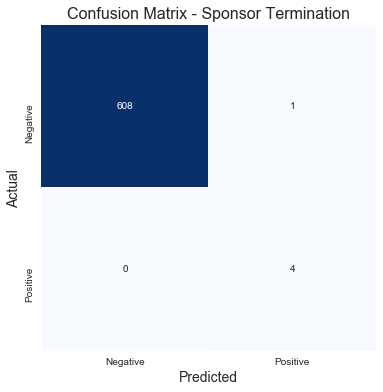

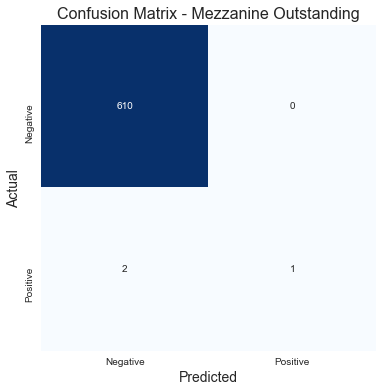

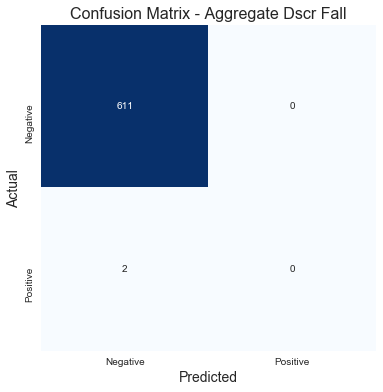

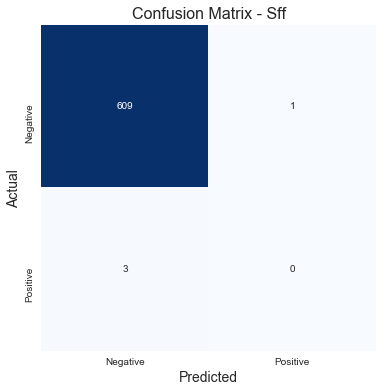

In [17]:
create_confusion_matrix(results_df)

In [18]:
# To allow us to better read the Sentences
pd.set_option('display.max_colwidth', None)

In [19]:
results_df.reset_index(inplace = True)

In [20]:
def create_summary_result_table(results_df):
    
    global final_misclassified_as_true
    global final_misclassified_as_false
    
    target_list = results_df['target'].values.tolist()
    final_columns = ['prediction', 'actual'] + target_list
    
    final_misclassified_as_true = pd.DataFrame(columns = final_columns)
    final_misclassified_as_false = pd.DataFrame(columns = final_columns)

    for row in results_df.itertuples(index = True, name = 'Pandas'):
        best_model = getattr(row, "model_result").best_estimator_
        preds = best_model.predict(getattr(row, "split_data")['X_test'])
        
        index_list = list(getattr(row, "split_data")['indices_test'])
        preds_list = list(preds.astype(int))
        actuals_list = list(getattr(row, "split_data")['y_test'].astype(int))
        
        results = pd.DataFrame({'index': index_list, 'prediction': preds_list, 'actual': actuals_list})
        results.set_index('index', inplace = True)
        
        misclassified = results[results['prediction'] != results['actual']]
        misclassified = misclassified.merge(df, how = 'left', left_index = True, right_index = True)
        misclassified_as_true = misclassified.loc[misclassified['prediction'] == 1]
        misclassified_as_false = misclassified.loc[misclassified['prediction'] == 0]
        
        misclassified_as_true_summary = misclassified_as_true.drop(columns = ['Document', 'Sentence', 'SentenceTokens', 'SentenceLemmas'])
        misclassified_as_false_summary = misclassified_as_false.drop(columns = ['Document', 'Sentence', 'SentenceTokens', 'SentenceLemmas'])
        
        
        misclassified_as_true_summary.loc[f'{getattr(row, "target")}',:] = misclassified_as_true.sum(axis = 0).copy(deep = True)
        misclassified_as_false_summary.loc[f'{getattr(row, "target")}',:] = misclassified_as_false.sum(axis = 0).copy(deep = True)

        
        final_misclassified_as_true = final_misclassified_as_true.append(misclassified_as_true_summary.iloc[-1], ignore_index = False)
        final_misclassified_as_false = final_misclassified_as_false.append(misclassified_as_false_summary.iloc[-1], ignore_index = False)
        
    return final_misclassified_as_true
    return final_misclassified_as_false
        
 

In [21]:
create_summary_result_table(results_df)

,prediction,actual,nontrigger,loan_default,unspecified,debt_yield_fall,mezzanine_default,tenant_failure,bankruptcy,aggregate_debt_yield_fall,dscr_fall,renovations,operator_termination,sponsor_termination,mezzanine_outstanding,aggregate_dscr_fall,sff
nontrigger,10.0,0.0,0,4,1,0,0,0,0,0,0,2,1,1,0,0,1
loan_default,7.0,0.0,5,0,0,0,0,1,0,0,0,0,0,0,0,0,1
unspecified,11.0,0.0,5,3,0,0,0,0,0,0,0,0,2,0,0,0,1
debt_yield_fall,1.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
mezzanine_default,1.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
tenant_failure,1.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
bankruptcy,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
aggregate_debt_yield_fall,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
dscr_fall,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
renovations,2.0,0.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [22]:
results_df.set_index('target', inplace = True)

In [23]:
final_misclassified_as_true

,prediction,actual,nontrigger,loan_default,unspecified,debt_yield_fall,mezzanine_default,tenant_failure,bankruptcy,aggregate_debt_yield_fall,dscr_fall,renovations,operator_termination,sponsor_termination,mezzanine_outstanding,aggregate_dscr_fall,sff
nontrigger,10.0,0.0,0,4,1,0,0,0,0,0,0,2,1,1,0,0,1
loan_default,7.0,0.0,5,0,0,0,0,1,0,0,0,0,0,0,0,0,1
unspecified,11.0,0.0,5,3,0,0,0,0,0,0,0,0,2,0,0,0,1
debt_yield_fall,1.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
mezzanine_default,1.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
tenant_failure,1.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
bankruptcy,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
aggregate_debt_yield_fall,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
dscr_fall,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
renovations,2.0,0.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [24]:
final_misclassified_as_false = results_df[['count', 'train_score', 'test_score']].merge(final_misclassified_as_false, left_index = True, right_index = True)
final_misclassified_as_false

,count,train_score,test_score,prediction,actual,nontrigger,loan_default,unspecified,debt_yield_fall,mezzanine_default,tenant_failure,bankruptcy,aggregate_debt_yield_fall,dscr_fall,renovations,operator_termination,sponsor_termination,mezzanine_outstanding,aggregate_dscr_fall,sff
nontrigger,1056,0.991837,0.976526,0.0,5.0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0
loan_default,459,0.993697,0.977162,0.0,7.0,0,7,0,2,2,2,0,0,0,0,0,0,0,0,0
unspecified,356,0.997899,0.959217,0.0,14.0,0,0,14,0,0,0,0,0,0,0,0,0,0,0,0
debt_yield_fall,204,1.000000,0.966667,0.0,3.0,0,2,0,3,1,0,0,0,0,0,0,0,0,0,2
mezzanine_default,105,1.000000,0.918033,0.0,4.0,0,4,0,3,4,0,0,1,0,0,0,0,0,0,1
tenant_failure,37,1.000000,0.857143,0.0,2.0,0,2,0,1,1,2,0,0,0,0,1,0,0,0,1
bankruptcy,77,0.990826,0.904762,0.0,4.0,0,4,0,3,0,0,4,0,0,1,0,0,0,1,0
aggregate_debt_yield_fall,18,1.000000,0.888889,0.0,1.0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
dscr_fall,25,1.000000,0.857143,0.0,2.0,0,1,0,0,1,0,1,0,2,0,0,0,0,0,0
renovations,24,0.969697,0.800000,0.0,1.0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0


In [25]:
final_misclassified_as_true = results_df[['count', 'train_score', 'test_score']].merge(final_misclassified_as_true, left_index = True, right_index = True)
final_misclassified_as_true

,count,train_score,test_score,prediction,actual,nontrigger,loan_default,unspecified,debt_yield_fall,mezzanine_default,tenant_failure,bankruptcy,aggregate_debt_yield_fall,dscr_fall,renovations,operator_termination,sponsor_termination,mezzanine_outstanding,aggregate_dscr_fall,sff
nontrigger,1056,0.991837,0.976526,10.0,0.0,0,4,1,0,0,0,0,0,0,2,1,1,0,0,1
loan_default,459,0.993697,0.977162,7.0,0.0,5,0,0,0,0,1,0,0,0,0,0,0,0,0,1
unspecified,356,0.997899,0.959217,11.0,0.0,5,3,0,0,0,0,0,0,0,0,2,0,0,0,1
debt_yield_fall,204,1.000000,0.966667,1.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
mezzanine_default,105,1.000000,0.918033,1.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
tenant_failure,37,1.000000,0.857143,1.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
bankruptcy,77,0.990826,0.904762,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
aggregate_debt_yield_fall,18,1.000000,0.888889,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
dscr_fall,25,1.000000,0.857143,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
renovations,24,0.969697,0.800000,2.0,0.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## BREAK: OLD CODE BELOW

## Import Data

In [ ]:
# Import the CSV file
# raw_df = pd.read_csv('../data/sasb_cash_trap_triggers.csv')

In [ ]:
# Import the CSV file
raw_df = pd.read_csv('../data/sasb_cash_trap_triggers_06_04_20.csv')

In [ ]:
# Review the first few rows of the data set
raw_df.head()

In [ ]:
# Check size of the data set
raw_df.shape

In [ ]:
raw_df = raw_df[['Document', 'Sentence', 'Trigger', 'Multiclass']]

In [ ]:
# Check for null values
raw_df.isnull().sum()

In [ ]:
raw_df.dropna()
raw_df.shape

In [ ]:
raw_df.head()

## Data Cleaning

In [ ]:
# Review number of Trigger types
raw_df['Trigger'].value_counts()

In [ ]:
# Convert each category to Title format (to remove discrepancies based on capitalization)
raw_df['Trigger'] = raw_df['Trigger'].str.title()

In [ ]:
# Some data fixes
raw_df['Trigger'] = raw_df['Trigger'].str.replace('Falll', 'Fall')
raw_df.loc[raw_df['Trigger'] == 'Aggregate Debt Yield', 'Trigger'] = 'Aggregate Debt Yield Fall'

In [ ]:
# Some dollar sign symbols are causing problems - will remove them here
raw_df['Sentence'] = raw_df['Sentence'].replace({'\$':''}, regex = True)

In [ ]:
# Review clean Trigger Types
raw_df['Trigger'].value_counts()

In [ ]:
# Drop Multiclass column since it isn't needed
raw_df = raw_df.drop('Multiclass', axis = 1)
raw_df.head()

In [ ]:
raw_df.shape

In [ ]:
# Count the number of distinct documents
num_docs = raw_df['Document'].nunique()
print(f'{num_docs} unique documents have been included in the data set')

In [ ]:
# Review the distinct documents and the number of Trigger events identified for each
raw_df['Document'].value_counts()

In [ ]:
# Summarize the trigger counts for the existing Document set
max_triggers = raw_df['Document'].value_counts().max()
min_triggers = raw_df['Document'].value_counts().min()
print(f'The {num_docs} Documents have tag counts that range from {min_triggers} to {max_triggers}.')

In [ ]:
raw_df.head()

In [ ]:
# Review new number of Trigger types
raw_df['Trigger'].value_counts()

In [ ]:
trigger_order = raw_df['Trigger'].value_counts().sort_values(ascending = False).index

fig = plt.gcf()
fig.set_size_inches(8, 8)
ax = sns.countplot(y=raw_df['Trigger'], data=raw_df, orient = 'h', order = trigger_order)
ax.set_title('Number of Trigger Types');

for p in ax.patches:
    ax.annotate(int(p.get_width()),((p.get_x() + p.get_width()), p.get_y()), xytext=(17, -15),fontsize=9,textcoords='offset points', horizontalalignment='right')
    
#https://stackoverflow.com/questions/50190409/how-to-annotate-horizontal-seaborn-countplots

In [ ]:
# Review new distinct documents and the number of Trigger events identified for each
raw_df['Document'].value_counts()

In [ ]:
raw_df.dtypes

## Reshape the Data

In this section, we'll reshape the data, such that each sentence is represented once, with separate categorization columns for each Trigger type

In [ ]:
# Reshape our original dataframe
df = reshape_trigger_representation(raw_df)

In [ ]:
df.head(5)

In [ ]:
# Export reshaped to CSV file
#df.to_csv('../data/reshaped_06_04_20.csv')

In [ ]:
# Create list of tag types (for later modeling)
trigger_list = list(df.columns)
trigger_list

In [ ]:
if 'Document' in trigger_list: trigger_list.remove('Document')
if 'Sentence' in trigger_list: trigger_list.remove('Sentence')
trigger_list

In [ ]:
# Create a dataframe showing the document tagging details (removing sentence details)
doc_view = df.groupby('Document').sum()


In [ ]:
doc_view.T

In [ ]:
number_tag_types = doc_view.astype(bool).sum(axis=1)
number_tag_types

In [ ]:
print(f'The number of tags per document ranges from {number_tag_types.min()} to {number_tag_types.max()}.')

In [ ]:
# Create a sum column
doc_view['sum'] = doc_view.sum(axis = 1)
doc_view

In [ ]:
# Export reshaped to CSV file
#doc_view.to_csv('../data/doc_view_06_04_20.csv')

In [ ]:
# Isolate documents that don't have any Trigger tags (only nontriggers)
no_trigger_tags = list(doc_view.loc[doc_view['sum'] == doc_view['nontrigger']].index)
no_trigger_tags # Save document names to a list

In [ ]:
# we will remove any documents that have 0 Cash Trap Trigger clauses within the data set

to_remove = df[df['Document'].isin(no_trigger_tags)]
df = df.drop(to_remove.index)

In [ ]:
doc_view.T

## Natural Language Processing / Feature Engineering

In [ ]:
# Create a column with length of Sentence
df['sentence_char_count'] = df['Sentence'].str.len()

In [ ]:
df.head()

In [ ]:
nlp = spacy.load('en_core_web_sm', disable = ['ner', 'parser'])

In [ ]:
# Review a tokenized sample Sentence
[token.text for token in nlp(df['Sentence'][2])]

In [ ]:
# Review a lemmatized sample Sentence
[token.lemma_ for token in nlp(df['Sentence'][2])]

In [ ]:
def tokenize(text):
    doc = nlp(text)
    tokens = [token.text for token in doc]
    return ' '.join(tokens)

df['SentenceTokens'] = df['Sentence'].apply(tokenize)

In [ ]:
def lemmatize(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]
    return ' '.join(lemmas)

df['SentenceLemmas'] = df['Sentence'].apply(lemmatize)

In [ ]:
df.head()

In [ ]:
# Put all sentences into a list of review tokens
all_sentence_tokens = ' '.join(df['SentenceTokens'])
all_sentence_tokens[:75]

In [ ]:
# Put all sentences into a list of review lemmas
all_sentence_lemmas = ' '.join(df['SentenceLemmas'])
all_sentence_lemmas[:75]

In [ ]:
sentence_token_list = [token for token in all_sentence_tokens.split(' ')]
sentence_lemma_list = [lemma for lemma in all_sentence_lemmas.split(' ')]

In [ ]:
token_df = pd.Series(sentence_token_list)
lemma_df = pd.Series(sentence_lemma_list)

In [ ]:
# Plotting the raw token count
token_series = token_df.value_counts().head(15).sort_values(ascending = True)
ax = token_series.plot.barh(figsize = (6,6))
ax.set_xlabel('count')
ax.set_ylabel('token')
ax.set_title('Sentences: Raw Token Count');

In [ ]:
# Plotting the raw lemma count
lemma_series = lemma_df.value_counts().head(15).sort_values(ascending = True)
ax = lemma_series.plot.barh(figsize = (6,6))
ax.set_xlabel('count')
ax.set_ylabel('lemma')
ax.set_title('Sentences: Raw Lemma Count');

In [ ]:
# Remove punctuation, maintain letters and numbers
df['SentenceLemmas_nopunc'] = df['SentenceLemmas'].str.replace("[^a-zA-Z0-9#']", " ")

In [ ]:
# Put all SentenceLemmas_nopunc into a list
all_lemmas_nopunc = ' '.join(df['SentenceLemmas_nopunc'])
lemma_list_nopunc = [lemma for lemma in all_lemmas_nopunc.split(' ')]
lemma_list_nopunc = [lemma for lemma in lemma_list_nopunc if lemma not in ['']]
lemma_list_nopunc[:10]

In [ ]:
# Create a data series containing the list of words
lemma_df_nopunc = pd.Series(lemma_list_nopunc)
lemma_series_nopunc = lemma_df_nopunc.value_counts().head(15).sort_values(ascending = True)
ax = lemma_series_nopunc.plot.barh(figsize = (6,6))
ax.set_xlabel('count')
ax.set_ylabel('lemma')
ax.set_title('Sentences: Lemma Count, no punctuation');

In [ ]:
df['SentenceLemmas_nopunc'].head()

In [ ]:
df['SentenceLemmas_nopunc'] = df['SentenceLemmas_nopunc'].str.replace('\s{2,}', ' ')

In [ ]:
df['SentenceLemmas_nopunc'].head()

## Preprocessing and Preparation for Modeling

In [ ]:
short_stopwords = ['the', 'to', 'of', 'be', 'and', 'in', 'a']
short_stopwords2 = ['the', 'and', 'a', 'to', 'it', 'be', 'for', 'with', 'that']

In [ ]:
# Look at original stopword list
stopwords = list(STOP_WORDS)
stopwords

## Train/Test Split

In [ ]:
df.head()

In [ ]:
# Check our previously defined trigger list
trigger_list

In [ ]:
def prepare_train_test_split(dataframe_sentence_column, trigger_list):
    for trigger_type in trigger_list:
        target = trigger_type
        X = dataframe_sentence_column
        y=df[target]
        indices = df.index
        y = y.astype('int')
        X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, test_size = 0.3, stratify = y, random_state = RANDOM_STATE)
    

In [ ]:
# Start by predicting Loan Default trigger

#target = 'loan_default'


#X = df['Sentence']
#y = df[target]
#indices = df.index

#y = y.astype('int')

In [ ]:
#y.dtypes

In [ ]:
# Checking shape of X and y 
#print(f'X shape is {X.shape}')
#print(f'y shape is {y.shape}')

In [ ]:
#y.value_counts()

In [ ]:
#X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, test_size = 0.3, stratify = y, random_state = RANDOM_STATE)
#print(X_train.shape, y_train.shape)
#print(X_test.shape, y_test.shape)
#print(indices_train.shape, indices_test.shape)

In [ ]:
#X.head()

In [ ]:
#X_train.shape[0]

In [ ]:
#y_train.shape[0]

## Modeling

In [ ]:
def modeling_function(target):
    pipe_cvec_lr = Pipeline([('cvec', CountVectorizer()), ('lr', LogisticRegression(solver = 'liblinear', random_state = RANDOM_STATE))])
    lr_params = {
        'lr__ngram_range': [(1,2), (1,3), (1,4), (1,5), (1,6), (1,7), (1,8)],
        'lr__stop_words': [None, short_stopwords, short_stopwords2, stopwords],  
        'lr__max_features': [100, 200, 400, 600, 1000],
        'lr__min_df': [2],
        'lr__max_df': [.99],
        }

    gs_lr = GridSearchCV(pipe_cvec_lr, param_grid = lr_params, cv = 3, scoring = 'f1')

    # Start the timer.
    t0 = time.time()

    results_lr = gs_lr.fit(X_train, y_train)

    print(f'Seconds elapsed for fitting: {(time.time() - t0):.3f}') # How many seconds elapsed.

### CountVectorizer + Logistic Regression GridSearch and modeling

In [ ]:
# Define CVEC + Logistic Regression Pipeline
pipe_cvec = Pipeline([('cvec', CountVectorizer()), ('lr', LogisticRegression(solver = 'liblinear', random_state = RANDOM_STATE))])
cvec_params = {
    'cvec__ngram_range': [(1,2), (1,3), (1,4), (1,5), (1,6), (1,7), (1,8)],
    'cvec__stop_words': [None, short_stopwords, short_stopwords2, stopwords],  
    'cvec__max_features': [100, 200, 400, 600, 1000],
    'cvec__min_df': [2],
    'cvec__max_df': [.99],
    }

gs_cvec = GridSearchCV(pipe_cvec, param_grid = cvec_params, cv = 3, scoring = 'f1')

# Start the timer.
t0 = time.time()

results_cvec = gs_cvec.fit(X_train, y_train)

print(f'Seconds elapsed for fitting: {(time.time() - t0):.3f}') # How many seconds elapsed.



In [ ]:
t0 = time.time()
print(f'Training score is {results_cvec.score(X_train, y_train):.3f}')
print(f'Test score is {results_cvec.score(X_test, y_test):.3f}')
print(f'Cross Validation score is {cross_val_score(results_cvec.best_estimator_, X, y, cv = 3).mean():.3f}')
print(f'Seconds elapsed for score calculation: {(time.time() - t0):.3f}') # How many seconds elapsed.

In [ ]:
print(f'Best Score:{(results_cvec.best_score_):.3f}')
print(f'Best Parameters :{results_cvec.best_params_}')

### 5: CountVectorizor + Random Forest

In [ ]:
'''
# Define CVEC + Logistic Regression Pipeline
pipe_rf = Pipeline([('cvec', CountVectorizer()), ('rf', RandomForestClassifier(random_state = RANDOM_STATE, n_jobs = 2))])
rf_params = {
    'cvec__ngram_range': [(1,2), (1,3), (1,4), (1,5)],
    'cvec__stop_words': [None, short_stopwords, short_stopwords2],  
    'cvec__max_features': [100, 200, 400, 800],
    'cvec__min_df': [2],
    'cvec__max_df': [.99],
    'rf__max_depth': [4,5, 6],
    'rf__min_samples_split': [2,3],
    'rf__min_samples_leaf': [10, 12]
    }

gs_rf = GridSearchCV(pipe_rf, param_grid = rf_params, cv = 3, scoring = 'f1')

# Start the timer.
t0 = time.time()

results_rf = gs_rf.fit(X_train, y_train)

print(f'Seconds elapsed for fitting: {(time.time() - t0):.3f}') # How many seconds elapsed.

'''

In [ ]:
'''
t0 = time.time()
print(f'Training score is {results_rf.score(X_train, y_train):.3f}')
print(f'Test score is {results_rf.score(X_test, y_test):.3f}')
print(f'Cross Validation score is {cross_val_score(results_rf.best_estimator_, X, y, cv = 3).mean():.3f}')
print(f'Seconds elapsed for score calculation: {(time.time() - t0):.3f}') # How many seconds elapsed.
'''

In [ ]:
'''
print(f'Best Score: {results_rf.best_score_}')
print(f'Best Parameters: {results_rf.best_params_}')
'''

## Model Selection
- In this section we compare the Train and Test scores across the various models

In [ ]:
# Check Training Scores across all models
print(f'Baseline Score:                                {y_test.value_counts(normalize=True)[0]:.3f}')
print(f'CountVectorizer + LogisticRegression Accuracy: {results_cvec.score(X_train, y_train):.3f}')
# print(f'CountVectorizer + Random Forest Accuracy:      {results_rf.score(X_train, y_train):.3f}')

In [ ]:
# Check Testing Scores across all models
print(f'Baseline Score:                                {y_test.value_counts(normalize=True)[0]:.3f}')
print(f'CountVectorizer + LogisticRegression Accuracy: {results_cvec.score(X_test, y_test):.3f}')
# print(f'CountVectorizer + Random Forest Accuracy:      {results_rf.score(X_test, y_test):.3f}')

## Model Evaluation - Logistic Regression

In [ ]:
# Isolate the individual words and their coefficients
# Feature names (i.e., words in the Sentences):
names = results_cvec.best_estimator_.steps[0][1].get_feature_names()

# classifier (betas):
classifier = results_cvec.best_estimator_.named_steps['lr']

# https://stackoverflow.com/questions/43856280/return-coefficients-from-pipeline-object-in-sklearn

In [ ]:
# Extract coefficients from the classifier defined above
coef_cvec = np.array(classifier.coef_).tolist()[0]
coef_cvec[:10] #Look at 10 coefficients

In [ ]:
# Create zipped list of the word names with their corresponding beta coefficients
cvec_top_words = list(zip(names, coef_cvec))

In [ ]:
# Create final dataframe of words with their corresponding coefficients
df_cvec_coefs = pd.DataFrame(cvec_top_words).rename(columns = {0: 'word', 1: 'coef'}).sort_values(by = 'coef', ascending = True)

In [ ]:
# Top differentiating words and phrases for this Trigger type
df_cvec_coefs.tail(20).sort_values('coef', ascending = False)

In [ ]:
# Display top opposing words and phrases for this Trigger type
df_cvec_coefs.head(20)

In [ ]:
def coef_plot(category):
    '''
    Plots the top 10 and bottom 10 coefficients for the complexity category specified
    '''
    coefs_1 = df_cvec_coefs.sort_values(by=category, ascending=False).tail(10) # getting the top 10 coefficients
    coefs_2 = df_cvec_coefs.sort_values(by=category, ascending=False).head(10) # getting the bottom 10 coefficients
    coefs = pd.concat([coefs_2, coefs_1], axis = 0) # merging the two into one
    # plotting importance
    plt.figure(figsize=(10, 8)) # plotting the coefficients
    plt.title(f'Feature Coefficients for {target.replace("_", " ").title()}', fontsize=25)
    sns.set_style("darkgrid")
    sns.barplot(data=coefs,
                x=category,
                y='word',
                orient='h',
                palette = 'PuBuGn_d')
    plt.xlabel('coefficient', fontsize=15)
    plt.ylabel('feature', fontsize=15)
    plt.tick_params(labelsize=15)
coef_plot('coef')

## Calculating predictions and Confusion Matrix

In [ ]:
# Here, we isolate our best model & make predictions based on our test data
best_model = results_cvec.best_estimator_
preds = best_model.predict(X_test)

In [ ]:
# Checking our predictions
preds[:10]

In [ ]:
## Create a confusion matrix

cm_test = confusion_matrix(y_test, preds)
print('This is a confusion matrix for our test data vs predictions:')
print(cm_test)

In [ ]:
# Converting our confusion matrix into a dataframe
cm_test = pd.DataFrame(cm_test, columns=['Predicted Negative','Predicted Positive'], 
                       index=['Actual Negative','Actual Positive'])

In [ ]:
cm_test

In [ ]:
# Plot our confusion matrix
plt.figure(figsize = (6,6))
ax = plt.subplot()
sns.heatmap(cm_test, 
            annot=True, 
            ax = ax, 
            fmt='g', 
            cbar=False,
            cmap="Blues"); #annot=True to annotate cells

# labels, title and ticks
ax.set_title('Confusion Matrix - Trigger Prediction', size=16)
ax.set_xlabel('Predicted', size=14)
ax.set_ylabel('Actual', size=14)
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Positive']);

In [ ]:
# Setting up probabilities for the ROC curve
pred_proba = results_cvec.predict_proba(X_test)
preds = results_cvec.predict(X_test)

In [ ]:
fpr, tpr, _= roc_curve(y_test, pred_proba[:,1])
roc_auc = auc(fpr, tpr)
# Plot of a ROC curve for a specific class
plt.figure(figsize = (8,8))
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='baseline')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate', fontsize =20)
plt.ylabel('True Positive Rate', fontsize = 20)
plt.title('Receiver Operating Characteristic Curve', fontsize=18)
plt.legend(loc="lower right");

In [ ]:
# To allow us to better read the Sentences
pd.set_option('display.max_colwidth', None)

In [ ]:
result_cols = ['index', 'prediction', 'actual', 'model_input']
results = pd.DataFrame({'index': list(indices_test),'prediction': list(preds), 'actual': list(y_test), 'model_input': list(X_test)})

In [ ]:
# set index as index column
results.set_index('index', inplace = True)
results.head()

In [ ]:
misclassified = results[results['prediction'] != results['actual']]


In [ ]:
misclassified = misclassified.merge(df, how = 'left', left_index = True, right_index = True)

In [ ]:
misclassified = misclassified[['prediction', 'actual', 'model_input', 'Document', 'Sentence',
       'loan_default', 'aggregate_dscr_fall', 'dscr_fall', 'unspecified',
       'debt_yield_fall', 'aggregate_debt_yield_fall', 'mezzanine_default',
       'tenant_failure', 'mezzanine_outstanding', 'operator_termination',
       'bankruptcy', 'sponsor_termination', 'renovations', 'nontrigger']]

In [ ]:
misclassified.head()

In [ ]:
# misclassified['prediction'].astype('Int64')
# misclassified['actual'].astype('Int64')

In [ ]:
print(f'We incorrectly predicted the trigger type for {misclassified.shape[0]} sentences.')

In [ ]:
# Show the split of the misclassified predictions
misclassified['prediction'].value_counts()

## Review the Incorrect Predictions

### Misclassifications: wrongly predicted to be the trigger category

In [ ]:
misclassified_as_true = misclassified.loc[misclassified['prediction'] == 1]
misclassified_as_true

In [ ]:
misclassified_as_true_summary = misclassified_as_true[['prediction', 'actual', 'loan_default', 'aggregate_dscr_fall', 'dscr_fall', 'unspecified',
       'debt_yield_fall', 'aggregate_debt_yield_fall', 'mezzanine_default',
       'tenant_failure', 'mezzanine_outstanding', 'operator_termination',
       'bankruptcy', 'sponsor_termination', 'renovations', 'nontrigger']]


In [ ]:
misclassified_as_true_count = misclassified_as_true_summary.shape[0]
print(f'{misclassified_as_true_count} sentences were predicted to be the trigger category, but in fact were not this category.')

In [ ]:
misclassified_as_true_summary.loc[f'{target}_sum',:] = misclassified_as_true.sum(axis = 0).copy(deep = True)


In [ ]:
misclassified_as_true_summary

### Misclassifications: wrongly predicted NOT to be the trigger category

In [ ]:
misclassified_as_false = misclassified.loc[misclassified['prediction'] == 0]
misclassified_as_false

In [ ]:
misclassified_as_false_summary = misclassified_as_false[['prediction', 'actual', 'loan_default', 'aggregate_dscr_fall', 'dscr_fall', 'unspecified',
       'debt_yield_fall', 'aggregate_debt_yield_fall', 'mezzanine_default',
       'tenant_failure', 'mezzanine_outstanding', 'operator_termination',
       'bankruptcy', 'sponsor_termination', 'renovations', 'nontrigger']]


In [ ]:
misclassified_as_false_count = misclassified_as_false.shape[0]
print(f'{misclassified_as_false_count} sentences were predicted not to be the trigger category, but in fact were this trigger category.')

In [ ]:
misclassified_as_false_summary.loc[f'{target}_sum',:] = misclassified_as_false.sum(axis = 0).copy(deep = True)
misclassified_as_false_summary

### Export Misclassification summaries

In [ ]:
# Export to CSV file
#misclassified_as_false_summary.to_csv(f'../data/misclassified/{target}_misclassified_as_false_06_04_20.csv')
#misclassified_as_true_summary.to_csv(f'../data/misclassified/{target}_misclassified_as_true_06_04_20.csv')